In [9]:
import pandas as pd

data_dictionary_path = "/Users/shuyachen/Desktop/data/heloc_data_dictionary-2.xlsx"
dataset_path = "/Users/shuyachen/Desktop/heloc_dataset_v1.csv"

heloc_data = pd.read_csv(dataset_path)

X = heloc_data.drop(columns=['RiskPerformance'])
y = heloc_data['RiskPerformance'].map({'Good': 1, 'Bad': 0})  # Convert to binary classification


In [11]:
!pip install scikit-learn

In [13]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

# Identify columns with missing value indicators (-7, -8, -9)
missing_value_columns = X.isin([-7, -8, -9]).any()

# Replace missing value indicators with the median of each respective column
for col in X.columns[missing_value_columns]:
    median_value = X[col].replace([-7, -8, -9], pd.NA).median()
    X[col] = X[col].replace([-7, -8, -9], median_value)

# Split dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train a Random Forest model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train_scaled, y_train)

# Predictions (Get Probability Scores)
y_proba = rf_model.predict_proba(X_test_scaled)[:, 1]  # Probability of being 'Good'

# **Custom Decision Threshold**
threshold = 0.6  # Adjusting based on cost & FNR constraints

# Convert probabilities to class labels based on the threshold
y_pred_adjusted = (y_proba >= threshold).astype(int)

# Evaluate performance
auc_roc = roc_auc_score(y_test, y_proba)
precision = precision_score(y_test, y_pred_adjusted)
recall = recall_score(y_test, y_pred_adjusted)
f1 = f1_score(y_test, y_pred_adjusted)
conf_matrix = confusion_matrix(y_test, y_pred_adjusted)
report = classification_report(y_test, y_pred_adjusted)

# **Banking-Related Categorization:**
# Applications are now classified as:
# - "Rejected Outright" if y_proba < threshold
# - "Sent for Review" if y_proba >= threshold
decision_results = pd.DataFrame({
    "Actual": y_test,
    "Predicted_Probability": y_proba,
    "Decision": ["Sent for Review" if p >= threshold else "Rejected Outright" for p in y_proba]
})

# Display results
performance_metrics = {
    "AUC-ROC": auc_roc,
    "Precision": precision,
    "Recall": recall,
    "F1-score": f1
}

# Show confusion matrix and decision breakdown
# Print Performance Metrics
print("Performance Metrics:")
print(performance_metrics)

# Display Confusion Matrix
conf_matrix_df = pd.DataFrame(conf_matrix, index=["Actual Bad", "Actual Good"], columns=["Predicted Bad", "Predicted Good"])
print("\nConfusion Matrix:")
print(conf_matrix_df)

# Print Classification Report
print("\nClassification Report:")
print(report)

# Display Sample Decision Results
print("\nSample Decision Results:")
print(decision_results.head(20))


Performance Metrics:
{'AUC-ROC': np.float64(0.7930856227106227), 'Precision': 0.7691256830601093, 'Recall': 0.563, 'F1-score': 0.6501154734411085}

Confusion Matrix:
             Predicted Bad  Predicted Good
Actual Bad             923             169
Actual Good            437             563

Classification Report:
              precision    recall  f1-score   support

           0       0.68      0.85      0.75      1092
           1       0.77      0.56      0.65      1000

    accuracy                           0.71      2092
   macro avg       0.72      0.70      0.70      2092
weighted avg       0.72      0.71      0.70      2092


Sample Decision Results:
      Actual  Predicted_Probability           Decision
5685       1               0.370000  Rejected Outright
3684       1               0.540000  Rejected Outright
4229       1               0.650000    Sent for Review
2895       1               0.690000    Sent for Review
5159       0               0.220000  Rejected Outrigh

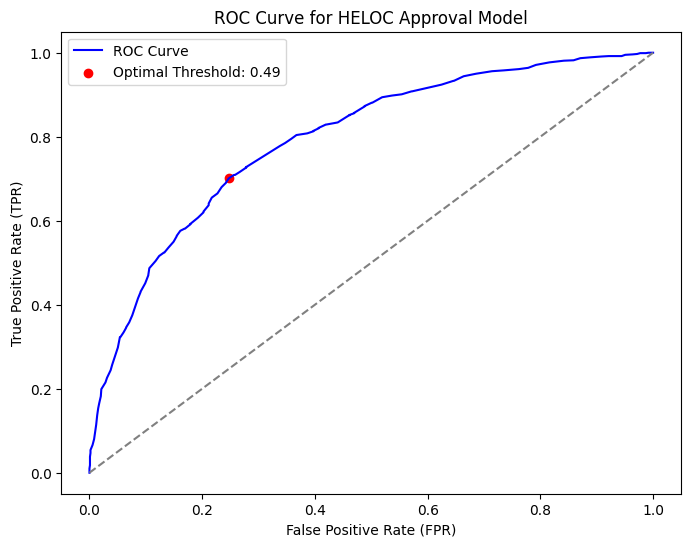

Optimal Decision Threshold: 0.49


In [17]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

# Identify columns with missing value indicators (-7, -8, -9)
missing_value_columns = X.columns[X.isin([-7, -8, -9]).any()]

# Replace missing value indicators with the median of each respective column
for col in X.columns[missing_value_columns]:
    median_value = X[col].replace([-7, -8, -9], pd.NA).median()
    X[col] = X[col].replace([-7, -8, -9], median_value)

# Split dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train a Random Forest model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train_scaled, y_train)

# Predictions (Get Probability Scores)
y_proba = rf_model.predict_proba(X_test_scaled)[:, 1]  # Probability of being 'Good'



# Compute ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_proba)

# Find the optimal threshold (Closest to Perfect Classification)
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]

# ✅ Correct way to plot ROC Curve
plt.figure(figsize=(8, 6))  # Ensure plt is correctly imported
plt.plot(fpr, tpr, label="ROC Curve", color="blue")
plt.scatter(fpr[optimal_idx], tpr[optimal_idx], color="red", label=f"Optimal Threshold: {optimal_threshold:.2f}")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")  # Random classifier reference
plt.xlabel("False Positive Rate (FPR)")
plt.ylabel("True Positive Rate (TPR)")
plt.title("ROC Curve for HELOC Approval Model")
plt.legend()
plt.show()

print(f"Optimal Decision Threshold: {optimal_threshold:.2f}")

In [7]:
!pip install shap

In [13]:
!pip install numpy==2.1

In [55]:
conda remove numpy

Channels:
 - defaults
 - conda-forge
Platform: osx-arm64
Solving environment: done

## Package Plan ##

  environment location: /opt/anaconda3/envs/gba462P

  removed specs:
    - numpy


The following packages will be REMOVED:

  blas-1.0-openblas
  libgfortran-5.0.0-11_3_0_hca03da5_28
  libgfortran5-11.3.0-h009349e_28
  libopenblas-0.3.21-h269037a_0
  llvm-openmp-14.0.6-hc6e5704_0
  numpy-2.1.3-py313h7c57ca2_0
  numpy-base-2.1.3-py313hb98e858_0




Preparing transaction: done
Verifying transaction: done
Executing transaction: done

Note: you may need to restart the kernel to use updated packages.


In [57]:
conda install numpy=2.1

Channels:
 - defaults
 - conda-forge
Platform: osx-arm64
Solving environment: done

## Package Plan ##

  environment location: /opt/anaconda3/envs/gba462P

  added / updated specs:
    - numpy=2.1


The following NEW packages will be INSTALLED:

  blas               pkgs/main/osx-arm64::blas-1.0-openblas 
  libgfortran        pkgs/main/osx-arm64::libgfortran-5.0.0-11_3_0_hca03da5_28 
  libgfortran5       pkgs/main/osx-arm64::libgfortran5-11.3.0-h009349e_28 
  libopenblas        pkgs/main/osx-arm64::libopenblas-0.3.21-h269037a_0 
  llvm-openmp        pkgs/main/osx-arm64::llvm-openmp-14.0.6-hc6e5704_0 
  numpy              pkgs/main/osx-arm64::numpy-2.1.3-py313h7c57ca2_0 
  numpy-base         pkgs/main/osx-arm64::numpy-base-2.1.3-py313hb98e858_0 




Preparing transaction: done
Verifying transaction: done
Executing transaction: done

Note: you may need to restart the kernel to use updated packages.


In [15]:
import numpy as np
print(np.__version__)  # Should print 2.1.0

2.1.3


In [17]:
!pip install matplotlib

In [19]:
! pip install pandas

In [23]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression

# Define models again
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(n_estimators=100, random_state=42)
}

# Train the best model (Gradient Boosting)
best_model = models["Gradient Boosting"]
best_model.fit(X_train_scaled, y_train)


GradientBoostingClassifier(random_state=42)

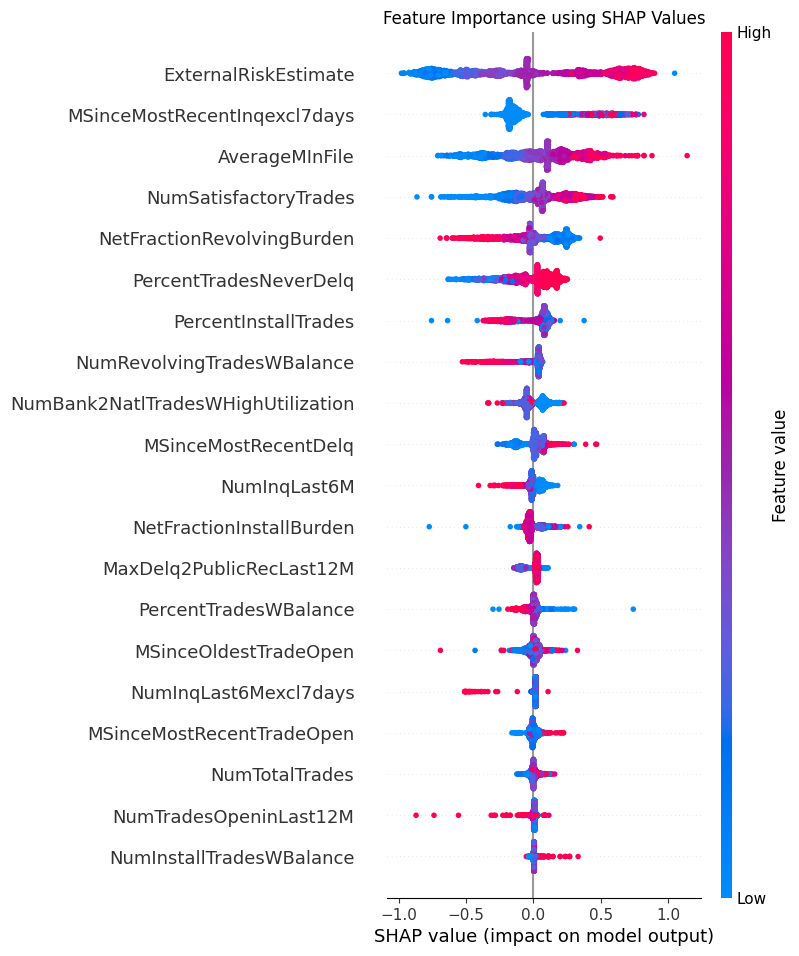

Top 10 Important Features:
                               Feature  Importance
0                 ExternalRiskEstimate    0.498561
14        MSinceMostRecentInqexcl7days    0.239345
3                       AverageMInFile    0.237601
4                NumSatisfactoryTrades    0.169028
17          NetFractionRevolvingBurden    0.160970
7               PercentTradesNeverDelq    0.138259
13                PercentInstallTrades    0.109727
19          NumRevolvingTradesWBalance    0.070434
21  NumBank2NatlTradesWHighUtilization    0.066067
8                 MSinceMostRecentDelq    0.064138


In [27]:
import shap
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Compute SHAP values for the best model (Gradient Boosting)
explainer = shap.Explainer(models["Gradient Boosting"], X_train_scaled)
shap_values = explainer(X_test_scaled)

# Summary plot of SHAP values (Feature Importance)
plt.figure(figsize=(10, 6))
shap.summary_plot(shap_values, X_test, show=False)
plt.title("Feature Importance using SHAP Values")
plt.show()

# Display feature importance as a DataFrame
feature_importance = pd.DataFrame({
    "Feature": X.columns,
    "Importance": np.abs(shap_values.values).mean(axis=0)
}).sort_values(by="Importance", ascending=False)

# Display the top 10 most important features
# Display the top 10 most important features using pandas
print("Top 10 Important Features:")
print(feature_importance.head(10))


